In [ ]:
# Gaussian Mixture Model (GMM) Clustering with K-means and Random Initialization

This Jupyter Notebook demonstrates the implementation and comparison of Gaussian Mixture Model (GMM) clustering using two different initialization methods: K-means and Random initialization. The notebook includes the following key steps:

1. **Data Preparation**: Loading and preparing the dataset for clustering.
2. **K-means Clustering**: Implementing the K-means clustering algorithm to initialize the GMM.
3. **GMM Initialization**: Initializing the GMM parameters (means, variances, and mixing coefficients) using the results from K-means or random initialization.
4. **Expectation-Maximization (EM) Algorithm**: Iteratively applying the E-step and M-step to optimize the GMM parameters.
5. **Convergence Analysis**: Analyzing the convergence behavior of the GMM with different initialization methods.
6. **Visualization**: Plotting the convergence histograms and the paths of the cluster means.

## Summary

The notebook provides a comprehensive workflow for clustering data using GMM with two initialization methods. It includes functions for K-means clustering, GMM initialization, and the EM algorithm. The convergence behavior of the GMM is analyzed and visualized for both K-means and random initialization methods, highlighting the differences in their performance and convergence rates. The visualizations help in understanding the clustering process and the effectiveness of the initialization methods.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('faithful.csv')
X = df[['eruptions', 'waiting']].values

In [3]:
def kmeans_clust(X, clusters=2, max_iter=100, eps=1e-4):
    n, d = X.shape
    centroids = X[np.random.choice(n, clusters, replace=False)]
    for _ in range(max_iter):
        dists = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(dists, axis=1)
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(clusters)])
        if np.all(np.abs(new_centroids - centroids) < eps):
            break
        centroids = new_centroids
    return centroids, labels

In [4]:
def init(X, clusters=2):
    n, d = X.shape
    mus = np.random.randn(clusters, d) * np.std(X, axis=0) + np.mean(X, axis=0)
    sigmas = np.ones(clusters) * np.var(X)
    pis = np.ones(clusters) / clusters
    return mus, sigmas, pis

In [5]:
def m_step(X, r):
    clusters = r.shape[1]
    n = X.shape[0]
    d = X.shape[1]
    mus_new = np.zeros((clusters, d))
    sigmas_new = np.zeros(clusters)
    pis_new = np.zeros(clusters)
    for i in range(clusters):
        r_sum = np.sum(r[:, i])
        mus_new[i] = np.sum(r[:, i].reshape(-1, 1) * X, axis=0) / r_sum
        sigmas_new[i] = np.sum(r[:, i] * np.sum((X - mus_new[i])**2, axis=1)) / (r_sum * d)
        pis_new[i] = r_sum / n
    return mus_new, sigmas_new, pis_new

In [6]:
def e_step(X, mus, sigmas, pis):
    clusters = mus.shape[0]
    n = X.shape[0]
    r = np.zeros((n, clusters))
    for i in range(clusters):
        diff = X - mus[i]
        exp_term = -0.5 * np.sum(diff**2, axis=1) / sigmas[i]
        r[:, i] = pis[i] * np.exp(exp_term) / np.sqrt(2 * np.pi * sigmas[i])
    r /= r.sum(axis=1, keepdims=True)
    return r

In [7]:
def log_likelihood(X, mus, sigmas, pis):
    clusters = mus.shape[0]
    ll_total = 0
    for i in range(clusters):
        diff = X - mus[i]
        exp_term = -0.5 * np.sum(diff**2, axis=1) / sigmas[i]
        lik = pis[i] * np.exp(exp_term) / np.sqrt(2 * np.pi * sigmas[i])
        ll_total += lik
    return np.sum(np.log(ll_total))

In [8]:
def gmm_init(X, centroids, labels, clusters=2):
    sigmas = np.zeros(clusters)
    pis = np.zeros(clusters)
    for i in range(clusters):
        cluster_pts = X[labels == i]
        sigmas[i] = np.mean(np.var(cluster_pts, axis=0))
        pis[i] = len(cluster_pts) / len(X)
    return centroids, sigmas, pis

In [9]:
def gmm_clust(X, clusters=2, max_iter=100, eps=1e-4, init_mode='kmeans'):
    if init_mode == 'kmeans':
        centroids, labels = kmeans_clust(X, clusters=clusters)
        mus, sigmas, pis = gmm_init(X, centroids, labels)
    else:
        mus, sigmas, pis = init(X, clusters)
    ll_hist = []
    mean_traj = [mus.copy()]
    for _ in range(max_iter):
        r = e_step(X, mus, sigmas, pis)
        mus, sigmas, pis = m_step(X, r)
        mean_traj.append(mus.copy())
        ll_val = log_likelihood(X, mus, sigmas, pis)
        ll_hist.append(ll_val)
        if _ > 0 and abs(ll_hist[-1] - ll_hist[-2]) < eps:
            break
    return mus, sigmas, pis, ll_hist, mean_traj, _

In [10]:
iter_hist_kmeans = []
traj_hist_kmeans = []
for _ in range(50):
    m1, m2, m3, ll_vals, means_hist, num_iters = gmm_clust(X, init_mode='kmeans')
    iter_hist_kmeans.append(num_iters)
    traj_hist_kmeans.append(means_hist)

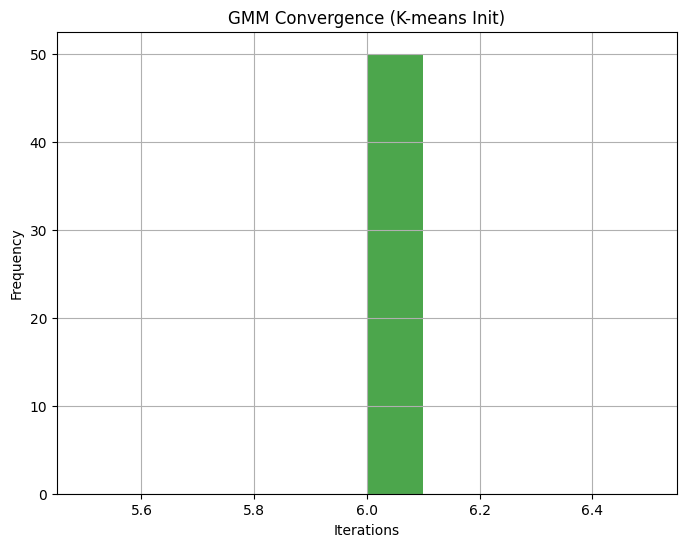

In [11]:
plt.figure(figsize=(8, 6))
plt.hist(iter_hist_kmeans, bins=10, color='g', alpha=0.7)
plt.title('GMM Convergence (K-means Init)')
plt.xlabel('Iterations')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [12]:
means_hist_kmeans = np.array(traj_hist_kmeans[0])
mean1_kmeans = means_hist_kmeans[:, 0, :]
mean2_kmeans = means_hist_kmeans[:, 1, :]

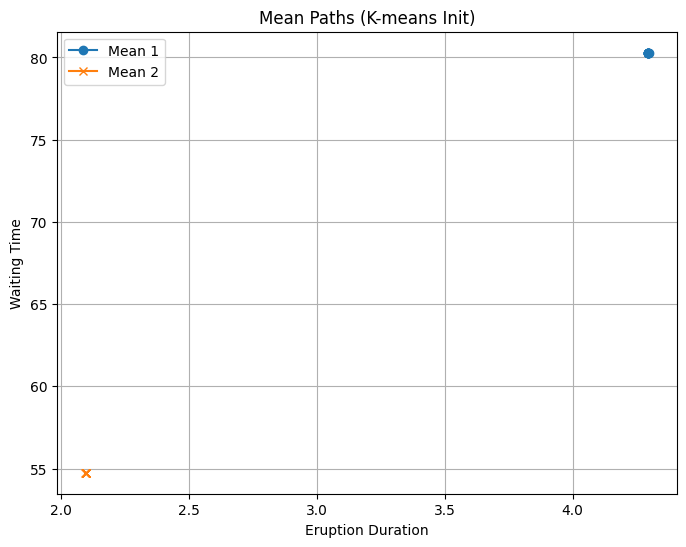

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(mean1_kmeans[:, 0], mean1_kmeans[:, 1], 'o-', label='Mean 1')
plt.plot(mean2_kmeans[:, 0], mean2_kmeans[:, 1], 'x-', label='Mean 2')
plt.title('Mean Paths (K-means Init)')
plt.xlabel('Eruption Duration')
plt.ylabel('Waiting Time')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
iter_hist_random = []
traj_hist_random = []
for _ in range(50):
    _, _, _, _, means_hist, num_iters = gmm_clust(X, init_mode='random')
    iter_hist_random.append(num_iters)
    traj_hist_random.append(means_hist)

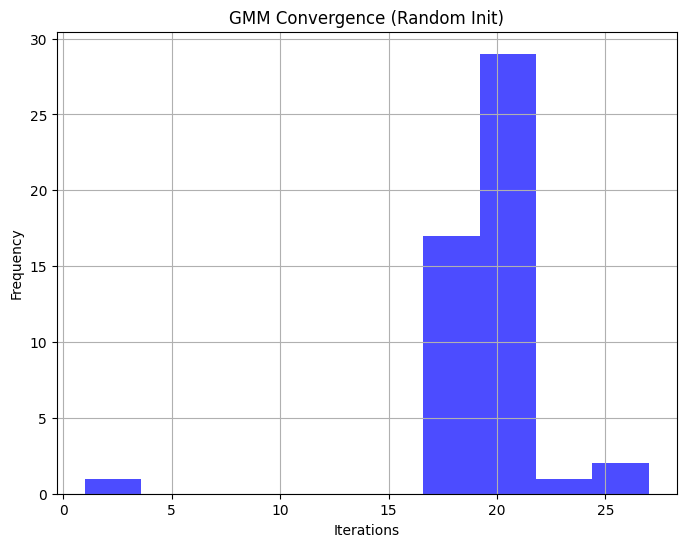

In [15]:
plt.figure(figsize=(8, 6))
plt.hist(iter_hist_random, bins=10, color='b', alpha=0.7)
plt.title('GMM Convergence (Random Init)')
plt.xlabel('Iterations')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [16]:
means_hist_random = np.array(traj_hist_random[0])
mean1_random = means_hist_random[:, 0, :]
mean2_random = means_hist_random[:, 1, :]

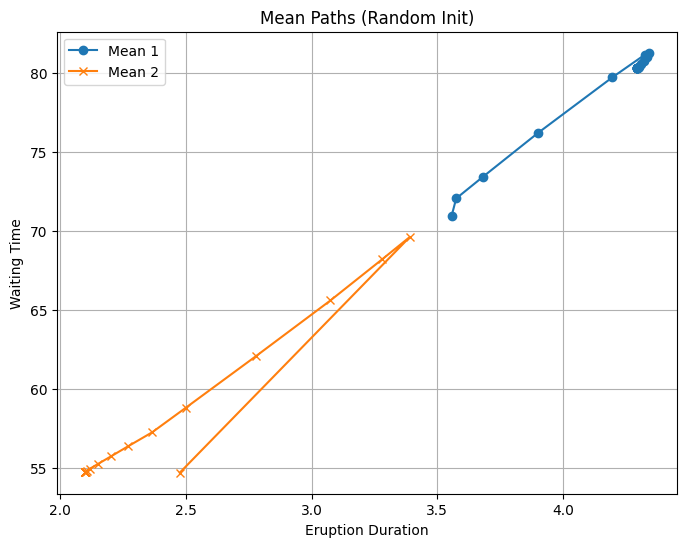

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(mean1_random[:, 0], mean1_random[:, 1], 'o-', label='Mean 1')
plt.plot(mean2_random[:, 0], mean2_random[:, 1], 'x-', label='Mean 2')
plt.title('Mean Paths (Random Init)')
plt.xlabel('Eruption Duration')
plt.ylabel('Waiting Time')
plt.legend()
plt.grid(True)
plt.show()